In [1]:
# %load main.py
#!/usr/bin/env python

# In[ ]:


import numpy as np
from scipy.signal import convolve2d
from PIL import Image as image # to load test image
import matplotlib.pyplot as plt # to plot images

#high pass & low pass filters
H = np.array([[1,1], [1,1]]) * 1/2
G1 = np.array([[1,1], [-1, -1]]) * 1/2
G2 = np.array([[1, -1], [1, -1]]) * 1/2
G3 = np.array([[1, -1], [-1, 1]]) * 1/2

newH = H
newG1 = np.array([[-1, -1], [1,1]]) * 1/2
newG2 = np.array([[-1, 1], [-1, 1]]) * 1/2
newG3 = G3

# 2D DWT
def downsample(im):
    return im[::2, ::2]

def conv_downsample(im, f):
    N = len(im)
    A = convolve2d(im, f, mode = 'same')
    B = np.zeros([N,N])
    for i in range(N):
        for j in range(N):
            B[i, j] = A[(i+1)%N, (j+1)%N]
    return downsample(B)

def dwt2d(im, lvl):
    wavelet_coeft = []
    N = len(im)
    for i in range(lvl):
        w1 = conv_downsample(im, newG1)
        w2 = conv_downsample(im, newG2)
        w3 = conv_downsample(im, newG3)
        s = conv_downsample(im, newH)
        print(f"w1 shape: {w1.shape}, w2 shape: {w2.shape}, w3 shape: {w3.shape}, s shape: {s.shape}")
        
        wavelet_coeft.append((w1, w2, w3, s)) # supposed to throw s away (unless it is the last level) but i will just not include it in the matrix later on

        im = s # for the next level
                                 
    # putting into matrix
    C = np.zeros([N,N])
    for i in range(lvl):
        w1, w2, w3, s = wavelet_coeft[i]
        j = 2 ** (i+1)
        k = 2 ** (i)
        C[N//j:N//k , :N//j] = w1
        C[:N//j , N//j:N//k] = w2
        C[N//j:N//k , N//j:N//k] = w3
    
    # last level for s
    C[:N//2**(lvl) , :N//2**(lvl)] = wavelet_coeft[-1][-1] # s
    return C

# 2D iDWT
def upsample(im):
    N = len(im)
    A = np.zeros([N*2,N*2])
    for i in range(N):
        for j in range(N):
            A[2*i, 2*j] = im[i, j]
    return A

def conv_upsample(im, f):
    A = convolve2d(upsample(im), f, mode = 'same')
    return A

def idwt2d(coef, lvl):
    N = len(coef)
    s = coef[:N//2**(lvl) , :N//2**(lvl)]
    for i in range(lvl,0,-1):
        j = 2 ** (i)
        k = 2 ** (i-1)
        w1 = coef[N//j:N//k , :N//j]
        w2 = coef[:N//j , N//j:N//k]
        w3 = coef[N//j:N//k , N//j:N//k]
        print(f"w1 shape: {w1.shape}, w2 shape: {w2.shape}, w3 shape: {w3.shape}, s shape: {s.shape}")
        
        s = conv_upsample(s, H) + conv_upsample(w1, G1) + conv_upsample(w2, G2) + conv_upsample(w3, G3)
    return s

In [2]:
# importing test image
im1 = image.open('sample.png')

# conversion for gray-scale image
im1 = im1.convert('L') 
I = np.array(im1)
print("Array shape", I.shape)
I

Array shape (256, 256)


array([[156, 159, 158, ..., 151, 152, 152],
       [160, 154, 157, ..., 154, 155, 153],
       [156, 159, 158, ..., 151, 152, 152],
       ...,
       [114, 132, 123, ..., 135, 137, 114],
       [121, 126, 130, ..., 133, 130, 113],
       [121, 126, 130, ..., 133, 130, 113]], dtype=uint8)

w1 shape: (128, 128), w2 shape: (128, 128), w3 shape: (128, 128), s shape: (128, 128)
w1 shape: (64, 64), w2 shape: (64, 64), w3 shape: (64, 64), s shape: (64, 64)
Array shape (256, 256)
[[628.5  631.5  630.5  ...   2.     1.5    1.  ]
 [624.75 625.   624.75 ...   2.     1.5    1.  ]
 [621.25 629.25 634.75 ...   6.5   -4.5   -1.5 ]
 ...
 [ 12.5    2.     6.5  ... -21.5   -9.   -18.  ]
 [ -1.5   10.   -12.5  ...  11.   -22.    -9.  ]
 [  0.     0.     0.   ...   0.     0.     0.  ]]


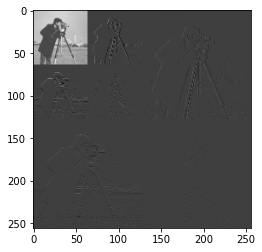

In [3]:
# testing DWT
A = dwt2d(I, 2)
print("Array shape", A.shape) # to check if it has the same shape as im
print(A)
plt.imshow(A, cmap = 'gray')

w1 shape: (64, 64), w2 shape: (64, 64), w3 shape: (64, 64), s shape: (64, 64)
w1 shape: (128, 128), w2 shape: (128, 128), w3 shape: (128, 128), s shape: (128, 128)
Array shape (256, 256)
[[156. 159. 158. ... 151. 152. 152.]
 [160. 154. 157. ... 154. 155. 153.]
 [156. 159. 158. ... 151. 152. 152.]
 ...
 [114. 132. 123. ... 135. 137. 114.]
 [121. 126. 130. ... 133. 130. 113.]
 [121. 126. 130. ... 133. 130. 113.]]


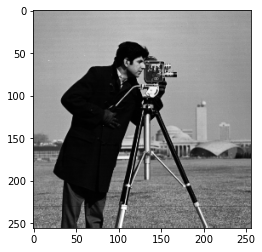

In [4]:
# testing iDWT
V = idwt2d(A, 2)

print("Array shape", V.shape)
print(V)
plt.imshow(V, cmap = 'gray')